# Tutorial: Using Occlusion-based Saliency to Explain Image Classification Models

## Introduction
This notebook contains a working example to demonstrate saliency map generation for black-box image classifiers.

Black-box image classifiers output class predictions for the entire image. To see saliency map generation for object detection on an image, see `Tutorial: Using DRISE to Explain Object Detection Models`.

This example will follow a use case where we transform an input image into saliency heatmaps based on our black-box classifier's output, visualizing the heatmaps over the input image.

### Prerequisites
Before starting, ensure the following:

- XAITK-Saliency is installed (see [`Installation`](../installation.rst)).
- **Software Requirements:**
  - Python 3.9+ installed.
  - pip (Python package manager) installed.
- **Basic Skills:** Familiarity with Python programming and using the terminal or command line.


To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/XAITK/xaitk-saliency/blob/master/docs/examples/OcclusionSaliency.ipynb)

Note for Colab users: after setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the README for more info).

In [1]:
import sys  # noqa

!{sys.executable} -m pip install -qU pip
!{sys.executable} -m pip install -q smqtk_classifier
!{sys.executable} -m pip install -q xaitk-saliency

## The Test Image
We will test this application on the following image from [ImageNet](https://www.image-net.org/challenges/LSVRC/index.php).
We know that this image contains the ImageNet classes of "boxer" and "tiger cat".

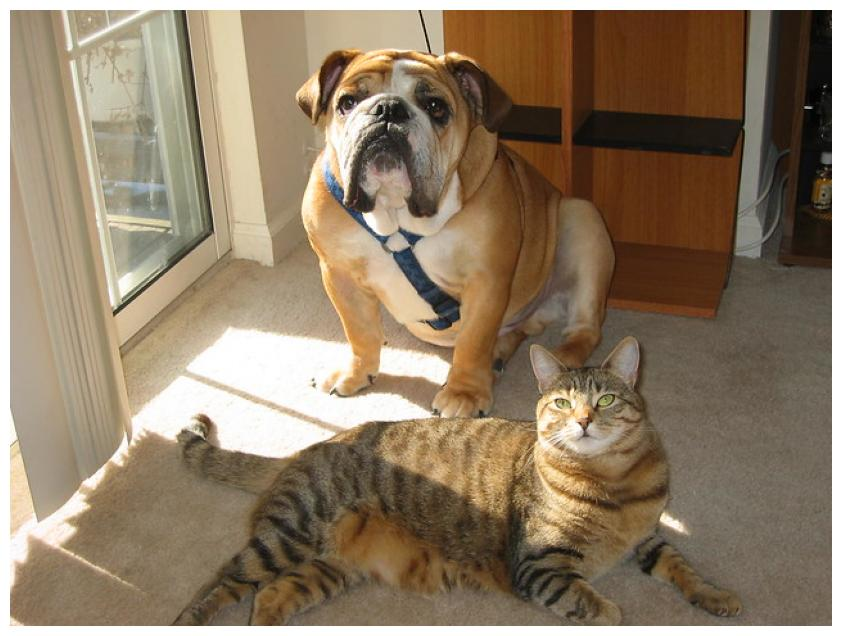

In [1]:
import os
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "jpeg"


os.makedirs("data", exist_ok=True)
test_image_filename = "data/catdog.jpg"
urllib.request.urlretrieve("https://farm1.staticflickr.com/74/202734059_fcce636dcd_z.jpg", test_image_filename)
plt.figure(figsize=(12, 8))
plt.axis("off")
ref_image = np.asarray(PIL.Image.open(test_image_filename))
_ = plt.imshow(ref_image)

## Load a Pre-trained Image Classification Model
In this example, we will use a basic PyTorch-based, pretrained [ResNet18](https://arxiv.org/abs/1512.03385) model and use its softmax output as classification confidences.
This will be wrapped up in an implementation of the `ClassifyImage` interface.
This sub-classing standardizes classifier operation with our API to support the varying ways classification is performed across toolkits and applications.
Since this model normally outputs 1000 classes, we will, for simplicity of example, constrain the output to the two classes that are relevant for our test image.

In [ ]:
# Set up our "black box" classifier using PyTorch and it's ImageNet pretrained ResNet18.
# We will constrain the output of our classifier here to the two classes that are relevant
# to our test image for the purposes of this example.
import warnings
from collections.abc import Iterable, Sequence
from typing import Any

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from smqtk_classifier import ClassifyImage
from typing_extensions import override

warnings.filterwarnings("ignore")

CUDA_AVAILABLE = torch.cuda.is_available()


model = models.resnet18(pretrained=True)
model = model.eval()
if CUDA_AVAILABLE:
    model = model.cuda()

# These are some simple helper functions to perform prediction with this model
model_input_size = (224, 224)
model_mean = [0.485, 0.456, 0.406]
model_loader = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(model_input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=model_mean, std=[0.229, 0.224, 0.225]),
    ],
)


# Grabbing the class labels associated with this model.
classes_file = "data/imagenet_classes.txt"
if not os.path.isfile(classes_file):
    !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O {classes_file}

with open(classes_file) as f:
    categories = [s.strip() for s in f.readlines()]


# For this test, we will use an image with both a cat and a dog in it.
# Let's only consider the saliency of two class predictions.
sal_class_labels = ["boxer", "tiger cat"]
sal_class_idxs = [categories.index(lbl) for lbl in sal_class_labels]


class TorchResnet18(ClassifyImage):
    """Blackbox model to output the two focus classes."""

    @override
    def get_labels(self) -> Sequence[str]:
        """Return class labels"""
        return sal_class_labels

    @override
    @torch.no_grad()
    def classify_images(self, image_iter: Iterable[np.ndarray]) -> dict[str, Any]:
        """Input may either be an NDaray, or some arbitrary iterable of NDarray images."""

        for img in image_iter:
            image_tensor = model_loader(img).unsqueeze(0)
            if CUDA_AVAILABLE:
                image_tensor = image_tensor.cuda()
            feature_vec = model(image_tensor)
            # Converting feature extractor output to probabilities.
            class_conf = torch.nn.functional.softmax(feature_vec, dim=1).cpu().detach().numpy().squeeze()
            # Only return the confidences for the focus classes
            yield dict(zip(sal_class_labels, class_conf[sal_class_idxs]))

    @override
    def get_config(self) -> dict[str, Any]:
        """Required by a parent class."""
        return {}


blackbox_classifier = TorchResnet18()

blackbox_fill = np.uint8(np.asarray(model_mean) * 255)

## Define the Saliency Algorithm

Below is the code to generate the saliency maps using `SlidingWindowStack`. The class has two parameters that affect saliency generation: `window_size` and `stride`. `window_size` is the size of the window to occlude and `stride` is the how much the window moves for each mask used in saliency map generation.

In [3]:
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack

gen_slidingwindow = SlidingWindowStack(window_size=(50, 50), stride=(20, 20), threads=4)
# This generator implementation has a slot for filling background occlusion,
# which our choice of classifier should ideally take for best operation.
gen_slidingwindow.fill = blackbox_fill

sal_maps = gen_slidingwindow(ref_image, blackbox_classifier)

## Visualization

Saliency maps will have a range of values from -1 to 1. Values close to 1 mean an increase of class confidence while values close to -1 mean a decrease in class confidence. Values around 0 have relatively low impact on class confidence. To relate the saliency map to the original image, the saliency map is overlaid onto the original image using a **colormap** (e.g., *jet*), highlighting influential regions. The meaning of the areas depends on the range of the color maps. In general:

- **Bright areas**: Increase class confidence.

- **Dark areas**: Decrease in class confidence.

Below is the first saliency map generated. The map classifies the image as a boxer and we can see how the lower body of the dog has a relatively high importance for classifying the image while the face of the cat has a relatively low importance. The rest of the image is mostly the yellow which is a middleground between the high and low sections.

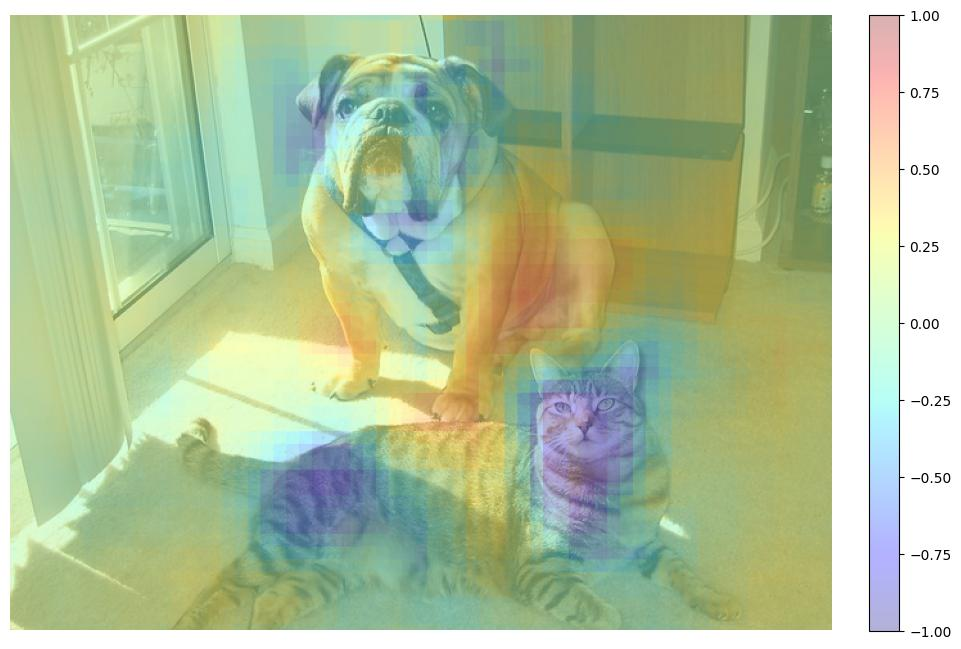

In [4]:
# Some magic numbers here to get colorbar to be roughly the same height
# as the plotted image.
colorbar_kwargs = {
    "fraction": 0.046 * (ref_image.shape[0] / ref_image.shape[1]),
    "pad": 0.04,
}
plt.figure(figsize=(12, 8))
plt.axis("off")
plt.imshow(ref_image, alpha=0.7)
plt.imshow(sal_maps[0], cmap="jet", alpha=0.3)
plt.colorbar(**colorbar_kwargs)
plt.clim(-1, 1)

Below is the second saliency map generated. The map classifies the image as a tiger cat and we can see how areas of high and low importance have swapped from the previous image. Since we only have two labels we are classifying in this example, the saliency maps end up being complementary.

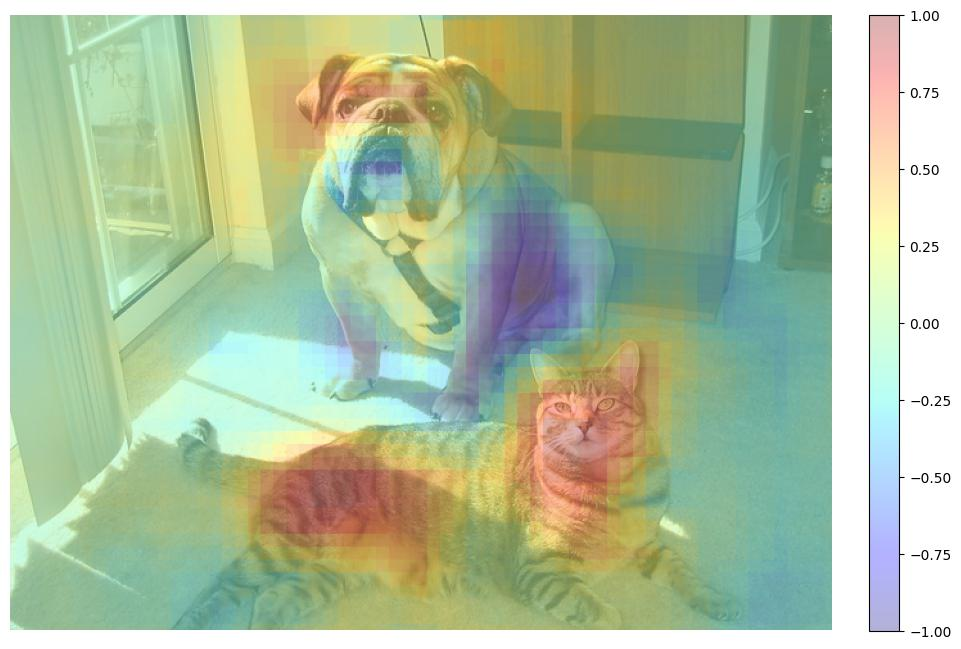

In [5]:
plt.figure(figsize=(12, 8))
plt.axis("off")
plt.imshow(ref_image, alpha=0.7)
plt.imshow(sal_maps[1], cmap="jet", alpha=0.3)
plt.colorbar(**colorbar_kwargs)
plt.clim(-1, 1)

## Next Steps

Now that you've completed this tutorial, see the [*How-To*](../review_process.rst) section for instructions on using other `Saliency Generation Examples`.

See the [*Reference*](../implementations.rst) section for code documentation.